# DCN

## 1. Install & Import Packages

In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 3.6MB 14.7MB/s 


In [3]:
import os
import pandas as pd

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import glob

In [4]:
def get_path(filename):
  return f'drive/MyDrive/Colab Notebooks/Data/{filename}'

glob.glob("drive/MyDrive/Colab Notebooks/Data/*")

['drive/MyDrive/Colab Notebooks/Data/Wine_Meta_v1_201129.json',
 'drive/MyDrive/Colab Notebooks/Data/User_Meta_v1_201129.json',
 'drive/MyDrive/Colab Notebooks/Data/PrevData',
 'drive/MyDrive/Colab Notebooks/Data/RAW_v2_201130.json',
 'drive/MyDrive/Colab Notebooks/Data/test_v2_201130.json',
 'drive/MyDrive/Colab Notebooks/Data/train_v2_201130.json',
 'drive/MyDrive/Colab Notebooks/Data/train_all_meta_v2.json',
 'drive/MyDrive/Colab Notebooks/Data/test_all_meta_v2.json',
 'drive/MyDrive/Colab Notebooks/Data/v1 (wine_id- userID - rating)',
 'drive/MyDrive/Colab Notebooks/Data/데이터 명세.gsheet',
 'drive/MyDrive/Colab Notebooks/Data/Wine_Token_v1_201129.json',
 'drive/MyDrive/Colab Notebooks/Data/Wine_taste_v1_201129.csv',
 'drive/MyDrive/Colab Notebooks/Data/user_clustering_train.csv',
 'drive/MyDrive/Colab Notebooks/Data/user_clustering_test.csv',
 'drive/MyDrive/Colab Notebooks/Data/food_token_one_hot.csv',
 'drive/MyDrive/Colab Notebooks/Data/Wine_Meta_final_201208.csv',
 'drive/My

In [5]:
train = pd.read_json(get_path('train_all_meta_v2.json'))
test = pd.read_json(get_path('test_all_meta_v2.json'))

In [6]:
train.body.value_counts().sum()

705693

## 2. Preprocess

In [7]:
train = train[~train.body.isna()].reset_index(drop=True)
test = test[~test.body.isna()].reset_index(drop=True)

In [8]:
INT_FEATURES = ["type_id", "body", "acidity", "like"]

for int_feature in INT_FEATURES:
  train[int_feature] = train[int_feature].astype(int)
  test[int_feature] = test[int_feature].astype(int)

train.country_code= train.country_code.fillna('un')
test.country_code= test.country_code.fillna('un')

In [9]:
train['grapes_id_unique'] = train.grapes_id.map(lambda x: x[0] if x else 0)
test['grapes_id_unique'] = test.grapes_id.map(lambda x: x[0] if x else 0)

In [10]:
# tf.keras.layers.experimental.preprocessing.
feature_names = ["userID", "wine_id", "country_code",  "like",
                 "type_id", "body", "acidity", "grapes_id_unique"]

In [11]:
for feature_name in feature_names:
  print(feature_name, train[feature_name].isna().sum())

userID 0
wine_id 0
country_code 0
like 0
type_id 0
body 0
acidity 0
grapes_id_unique 0


In [12]:
for feature_name in feature_names:
  print(feature_name, test[feature_name].isna().sum())

userID 0
wine_id 0
country_code 0
like 0
type_id 0
body 0
acidity 0
grapes_id_unique 0


In [13]:
str_features = ["userID", "wine_id", "country_code"]
int_features = ["type_id", "body", "acidity", "grapes_id_unique", "like"]

In [14]:
train_str_dict = {
    str_feature: [str(val).encode() for val in train[str_feature].values]
    for str_feature in str_features
}

train_int_dict = {
    int_feature: train[int_feature].values
    for int_feature in int_features
}

In [15]:
train_str_dict.update(train_int_dict)
train_str_dict.keys()

dict_keys(['userID', 'wine_id', 'country_code', 'type_id', 'body', 'acidity', 'grapes_id_unique', 'like'])

In [16]:
test_str_dict = {
    str_feature: [str(val).encode() for val in test[str_feature].values]
    for str_feature in str_features
}

test_int_dict = {
    int_feature: test[int_feature].values
    for int_feature in int_features
}

test_str_dict.update(test_int_dict)
test_str_dict.keys()

dict_keys(['userID', 'wine_id', 'country_code', 'type_id', 'body', 'acidity', 'grapes_id_unique', 'like'])

In [17]:
train = tf.data.Dataset.from_tensor_slices(train_str_dict)
test = tf.data.Dataset.from_tensor_slices(test_str_dict)

In [18]:
vocabularies = {}

for feature_name in feature_names:
  vocab = train.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [20]:
vocabularies

{'acidity': array([1, 2, 3]),
 'body': array([1, 2, 3, 4, 5]),
 'country_code': array([b'ar', b'at', b'au', b'br', b'ca', b'ch', b'cl', b'de', b'es',
        b'fr', b'gb', b'gr', b'hu', b'il', b'it', b'jp', b'lu', b'mx',
        b'nz', b'pt', b'ru', b'un', b'us', b'uy', b'za'], dtype=object),
 'grapes_id_unique': array([   0,    1,    2,    3,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   29,   31,   32,   33,   34,   35,   36,   37,
          38,   39,   40,   41,   42,   43,   44,   45,   46,   47,   48,
          49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          62,   63,   64,   67,   68,   69,   70,   71,   74,   75,   76,
          77,   78,   80,   81,   82,   83,   85,   86,   88,   89,   91,
          92,   93,   94,   96,   97,   98,  100,  101,  102,  103,  104,
         105,  106,  108,  109,  110,  111,  112,  114,  115,  116,  118,
         119,  120, 

## 3. Model

In [21]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["userID", "wine_id", "country_code"]
    int_features = ["type_id", "body", "acidity", "grapes_id_unique"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("like")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [32]:
learning_rate = 0.002

In [23]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [24]:
model = DCN(use_cross_layer=True, deep_layer_sizes=[192, 192], projection_dim=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

## 4. Train & Result

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds

cached_test_numpy = tfds.as_numpy(cached_test)
y_true = [item['like'] for item in cached_test_numpy]
y_true = np.concatenate(y_true)

In [27]:
def get_result(model):
  y_pred = model.predict(cached_test).flatten()
  y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]

  print(f"ROC: {roc_auc_score(y_true, y_pred)}")
  print(classification_report(y_true, y_pred_class))

In [28]:
history1 = model.fit(cached_train,  epochs=10, verbose=True)

Epoch 1/10
87/87 [==============================] - 10s 81ms/step - RMSE: 0.4794 - loss: 0.2291 - regularization_loss: 0.0000e+00 - total_loss: 0.2291
Epoch 2/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.4276 - loss: 0.1821 - regularization_loss: 0.0000e+00 - total_loss: 0.1821
Epoch 3/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.4108 - loss: 0.1674 - regularization_loss: 0.0000e+00 - total_loss: 0.1674
Epoch 4/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.3972 - loss: 0.1559 - regularization_loss: 0.0000e+00 - total_loss: 0.1559
Epoch 5/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.3878 - loss: 0.1485 - regularization_loss: 0.0000e+00 - total_loss: 0.1485
Epoch 6/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.3813 - loss: 0.1434 - regularization_loss: 0.0000e+00 - total_loss: 0.1434
Epoch 7/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.3786 - loss: 0.1415 - re

In [29]:
get_result(model)

ROC: 0.8222539098559614
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     81031
           1       0.78      0.76      0.77     93416

    accuracy                           0.76    174447
   macro avg       0.76      0.76      0.76    174447
weighted avg       0.76      0.76      0.76    174447



In [30]:
history2 = model.fit(cached_train,  epochs=10, verbose=True)
get_result(model)

Epoch 1/10
87/87 [==============================] - 2s 19ms/step - RMSE: 0.3556 - loss: 0.1246 - regularization_loss: 0.0000e+00 - total_loss: 0.1246
Epoch 2/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.3448 - loss: 0.1172 - regularization_loss: 0.0000e+00 - total_loss: 0.1172
Epoch 3/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.3378 - loss: 0.1123 - regularization_loss: 0.0000e+00 - total_loss: 0.1123
Epoch 4/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.3284 - loss: 0.1061 - regularization_loss: 0.0000e+00 - total_loss: 0.1061
Epoch 5/10
87/87 [==============================] - 2s 19ms/step - RMSE: 0.3255 - loss: 0.1045 - regularization_loss: 0.0000e+00 - total_loss: 0.1045
Epoch 6/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.3212 - loss: 0.1015 - regularization_loss: 0.0000e+00 - total_loss: 0.1015
Epoch 7/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.3145 - loss: 0.0971 - reg

In [31]:
history3 = model.fit(cached_train,  epochs=10, verbose=True)
get_result(model)

Epoch 1/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.2469 - loss: 0.0599 - regularization_loss: 0.0000e+00 - total_loss: 0.0599
Epoch 2/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.2366 - loss: 0.0549 - regularization_loss: 0.0000e+00 - total_loss: 0.0549
Epoch 3/10
87/87 [==============================] - 2s 22ms/step - RMSE: 0.2302 - loss: 0.0520 - regularization_loss: 0.0000e+00 - total_loss: 0.0520
Epoch 4/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.2272 - loss: 0.0506 - regularization_loss: 0.0000e+00 - total_loss: 0.0506
Epoch 5/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.2252 - loss: 0.0498 - regularization_loss: 0.0000e+00 - total_loss: 0.0498
Epoch 6/10
87/87 [==============================] - 2s 20ms/step - RMSE: 0.2228 - loss: 0.0488 - regularization_loss: 0.0000e+00 - total_loss: 0.0488
Epoch 7/10
87/87 [==============================] - 2s 21ms/step - RMSE: 0.2201 - loss: 0.0476 - reg

In [35]:
model.summary()

Model: "dcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32)                128       
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                192       
_________________________________________________________________
sequential_2 (Sequential)    (None, 32)                832       
_________________________________________________________________
sequential_6 (Sequential)    (None, 32)                12768     
_________________________________________________________________
sequential_3 (Sequential)    (None, 32)                256       
_________________________________________________________________
sequential (Sequential)      (None, 32)                203008    
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                1417600 

<Figure size 648x648 with 0 Axes>

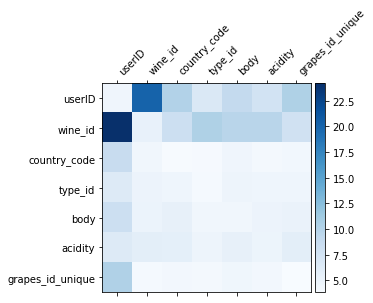

In [33]:
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

In [41]:
test.take(100).batch(100)

<BatchDataset shapes: {userID: (None,), wine_id: (None,), country_code: (None,), type_id: (None,), body: (None,), acidity: (None,), grapes_id_unique: (None,), like: (None,)}, types: {userID: tf.string, wine_id: tf.string, country_code: tf.string, type_id: tf.int64, body: tf.int64, acidity: tf.int64, grapes_id_unique: tf.int64, like: tf.int64}>

In [43]:
model

In [45]:
model.predict(cached_test)

array([[ 0.9059499 ],
       [ 0.929794  ],
       [ 0.96498656],
       ...,
       [ 0.8952126 ],
       [-0.00504744],
       [ 0.93719846]], dtype=float32)